In [1]:
# This is the best algorithm among all three Gibbs

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300


from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler


# select device: change to 'cpu' if there's no GPU device

In [3]:
import pickle as pkl
T, Y_all = pkl.load(open("time_series.pkl","rb"))

# encoding = (T>=0) & (T<2000)
# Y= Y_all[:,encoding]

pick = (T>=0) & (T<1000)
Y= Y_all[:,pick]


In [4]:
import sklearn
Y = sklearn.datasets.make_moons(n_samples=100, shuffle=True, noise=None, random_state=None)[0]
Y = Y[np.argsort(Y[:,0]),]
Y += np.random.normal(0,0.1, Y.shape)

In [5]:
n = Y.shape[0]

time_points = Y.shape[1]

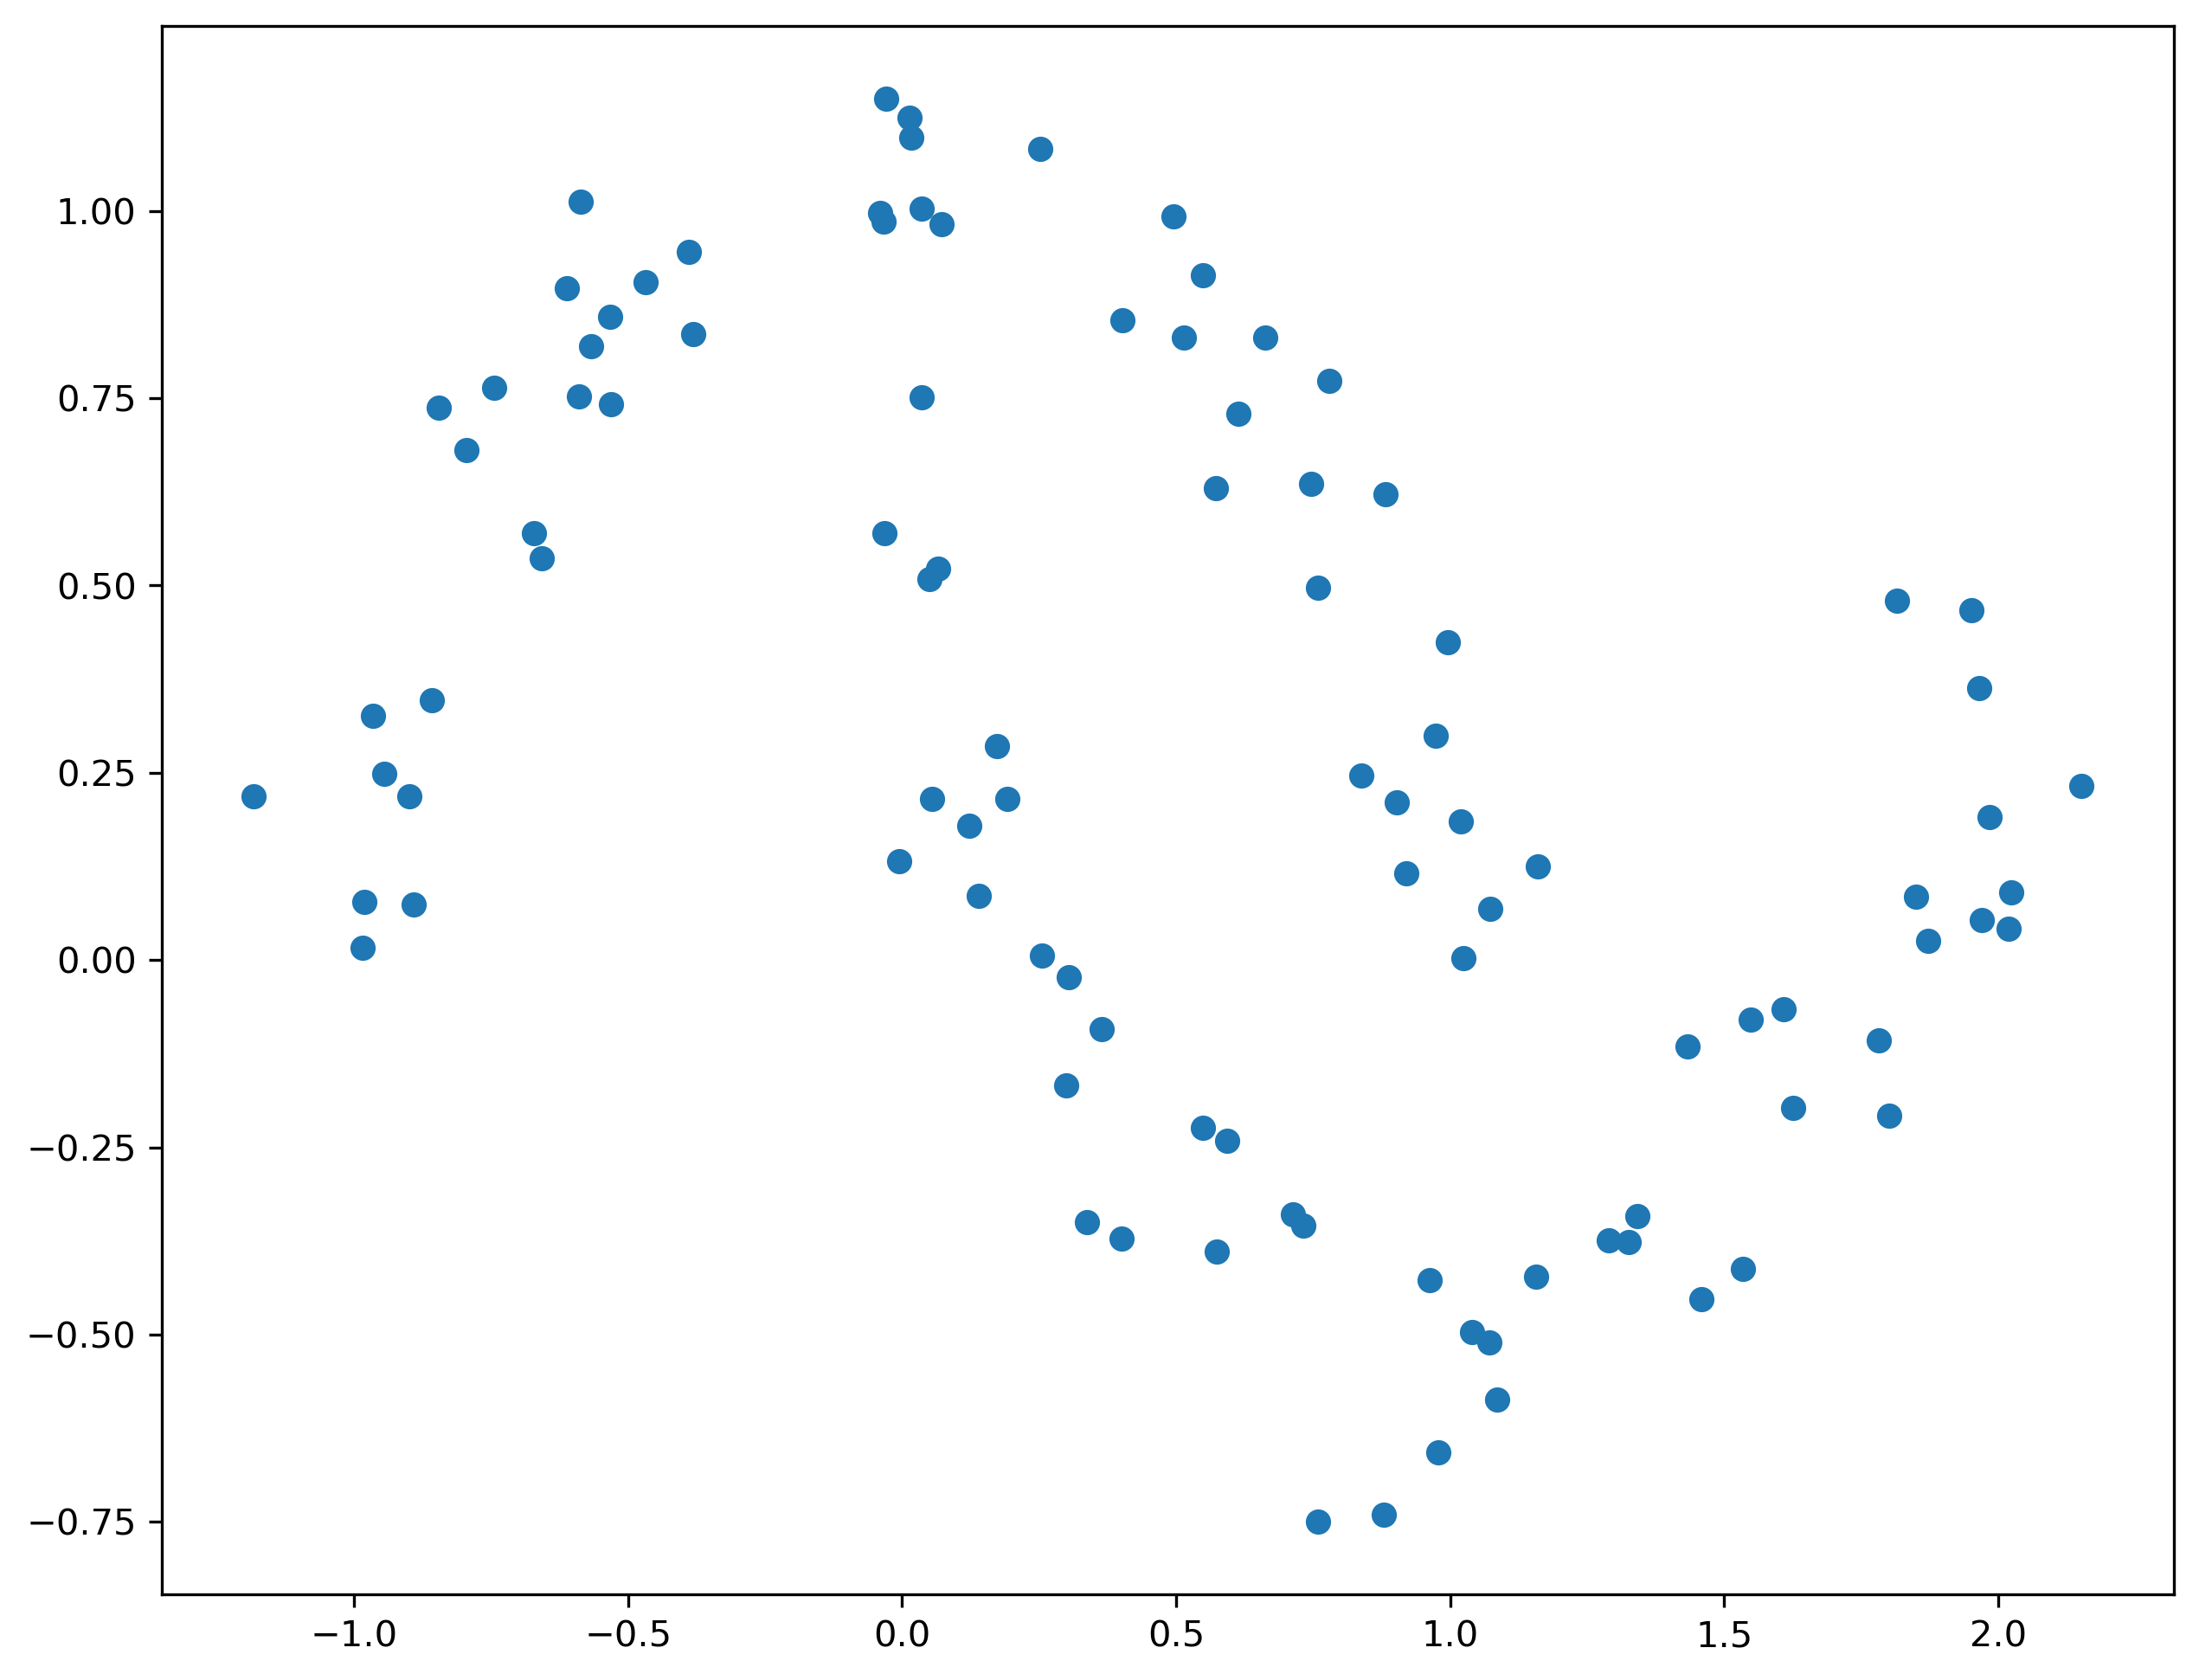

In [6]:
plt.scatter(Y[:,0],Y[:,1])

In [7]:
# Y = (Y- Y.mean(1,keepdims=True))/Y.std(1,keepdims=True)

In [8]:
time_points

2

In [9]:
Adj0 = np.zeros([n,n])

In [10]:
for i in range(n):
    for j in range(i):
        Adj0[i,j] = np.sum((Y[i]-Y[j])**2)
#         Adj0[i,j] = np.sum(np.abs(Y[i]-Y[j])) 
        Adj0[j,i] = Adj0[i,j]

In [11]:
def find_min_idx(x):
    k = x.argmin()
    ncol = x.shape[1]
    return int(k/ncol), k%ncol

In [12]:
def FindMST(A):

    n = A.shape[0]
    MST = np.zeros([n,n])

    Xl = list()
    Vl = list(range(n))
    Xl.append(0)
    Vl.remove(0)

    i = 0
    while len(Vl)>0:
        idx0, idx1 = find_min_idx(A[Xl][:,Vl])

        MST[Xl[idx0],Vl[idx1]]=1

        Xl.append(Vl[idx1])
        Vl.remove(Vl[idx1])

        i+=1
    
    return MST + MST.T

In [13]:
MST = FindMST(Adj0)
mst0 = MST.copy()

In [14]:
fullIdx = np.arange(n)

linked_dict = dict()
for i in range(n):
    linked_dict[i] = set(fullIdx[MST[i]==1])

In [15]:
def getSubgraph_with_j_not_i(linked_dict,i,j):
    
    if i == j:
        return set()
    
    # those connect to j:
    l = linked_dict[j].copy()
    
    # exclude i
    if i in l:
        l.remove(i)
    
    # those connect to each one in l, exclude j
    for j1 in l:
        l1 = getSubgraph_with_j_not_i(linked_dict,j,j1)
        # exclude i
        if i in l1:
            l1.remove(i)
        l = l.union(l1)

    return l

In [16]:
import copy

In [17]:
mst_trace = list()

In [18]:
MST = mst0.copy()

linked_dict = dict()
for i in range(n):
    linked_dict[i] = set(fullIdx[MST[i]==1])

In [19]:
linked_dict[0]

{2}

In [20]:
len(getSubgraph_with_j_not_i(linked_dict,0,64))

98

In [21]:
len(getSubgraph_with_j_not_i(linked_dict,64,0))

98

In [22]:
for k in range(1000):
    
    sigma2 = 1/ np.random.gamma((n-1)*time_points/2 , 1.0/ ( np.sum(MST*Adj0)/2/2), 1)
    logP =  -Adj0/sigma2/2.0

    i_list = list(range(n))
    np.random.shuffle(i_list)
    
    if k %50==0:
        print(k)

    for i in i_list:

        v_to_i = linked_dict[i] # vertices connecting i

        for j in list(v_to_i):

            candidate_idx_list =  getSubgraph_with_j_not_i(linked_dict, i, j) # vertices connecting to j but not i

            
            candidate_idx_list.add(j)
            candidate_idx_list = list(candidate_idx_list)
            
            
            if len(candidate_idx_list)>1:   

                choice = candidate_idx_list[np.argmax(logP[i,candidate_idx_list] + np.random.gumbel(0,1, len(candidate_idx_list)))]

                if choice != j :
                    MST[i,j] =0
                    MST[j,i] =0

                    MST[i, choice] =1
                    MST[choice,i ]=1
                    
                    linked_dict[i].remove(j)
                    linked_dict[j].remove(i)
                    linked_dict[i].add(choice)
                    linked_dict[choice].add(i)

    mst_trace.append(MST.copy())
np.abs(MST-mst0).sum()

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


284.0

In [23]:
mst_trace_arr = np.array(mst_trace)

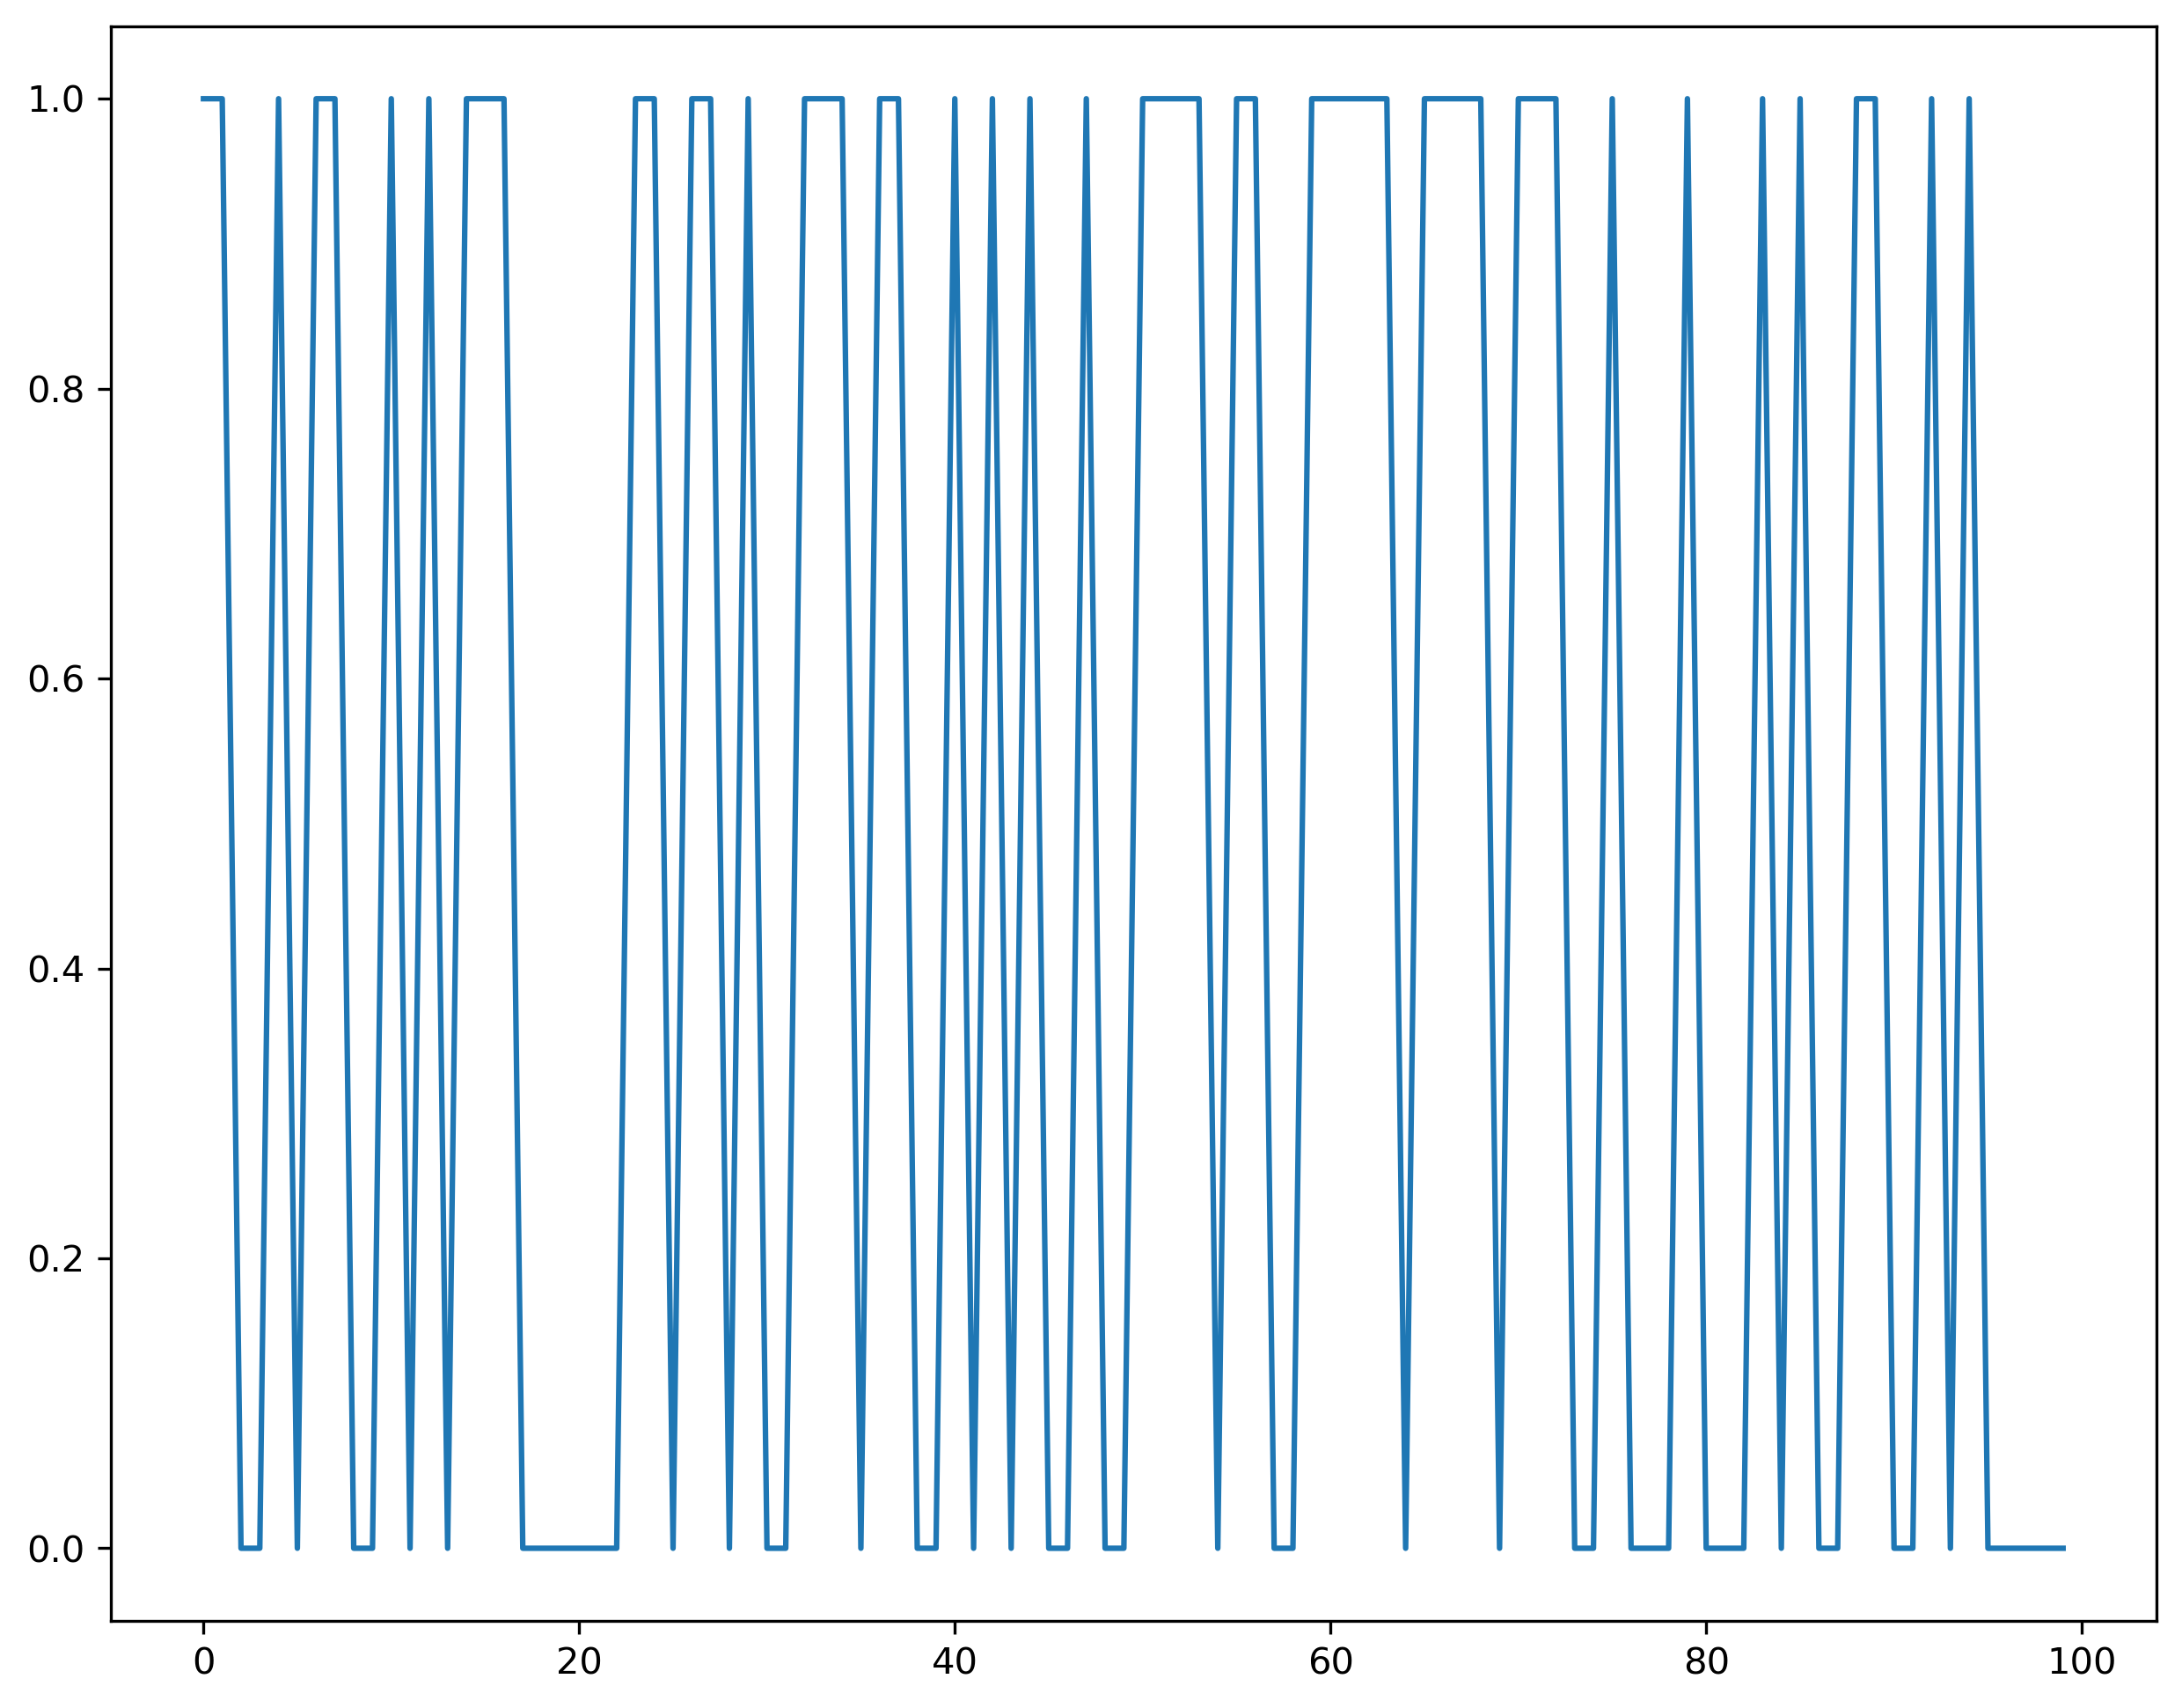

In [24]:
plt.plot(mst_trace_arr[:100,0,1])

In [25]:
mean_mst = mst_trace_arr.mean(0)

In [26]:
np.where(np.logical_and(mean_mst<0.7, mean_mst>0.3))

(array([ 0,  0,  1,  1,  1,  2,  2,  4,  4,  4,  4,  5,  5,  5,  6,  6,  6,
         6,  7,  7,  7,  8,  8,  9,  9, 10, 10, 11, 11, 12, 18, 21, 22, 23,
        23, 24, 24, 25, 25, 26, 26, 27, 27, 27, 28, 28, 28, 29, 30, 30, 31,
        31, 32, 32, 33, 34, 35, 35, 36, 36, 37, 37, 37, 38, 38, 39, 40, 40,
        40, 41, 41, 41, 42, 43, 43, 43, 44, 44, 44, 45, 45, 46, 46, 46, 47,
        47, 47, 47, 48, 48, 49, 49, 50, 50, 51, 52, 52, 52, 53, 53, 53, 54,
        54, 55, 55, 56, 57, 57, 58, 58, 58, 59, 59, 60, 60, 60, 61, 61, 61,
        62, 62, 62, 62, 63, 64, 64, 64, 65, 65, 66, 66, 67, 67, 68, 68, 69,
        69, 70, 70, 70, 71, 72, 72, 73, 73, 74, 75, 75, 75, 76, 76, 77, 77,
        77, 77, 78, 78, 79, 80, 80, 81, 82, 82, 83, 84, 84, 84, 85, 85, 86,
        86, 86, 87, 88, 88, 89, 90, 90, 91, 91, 91, 92, 93, 93, 94, 94, 95,
        95, 96, 96, 96, 97, 98, 98, 99, 99]),
 array([ 1,  2,  0,  2,  4,  0,  1,  1,  5,  6,  7,  4,  6,  7,  4,  5,  7,
        11,  4,  5,  6,  9, 10,  8, 10,  8

In [27]:
# plt.plot(mst_trace_arr[:100,96,97])

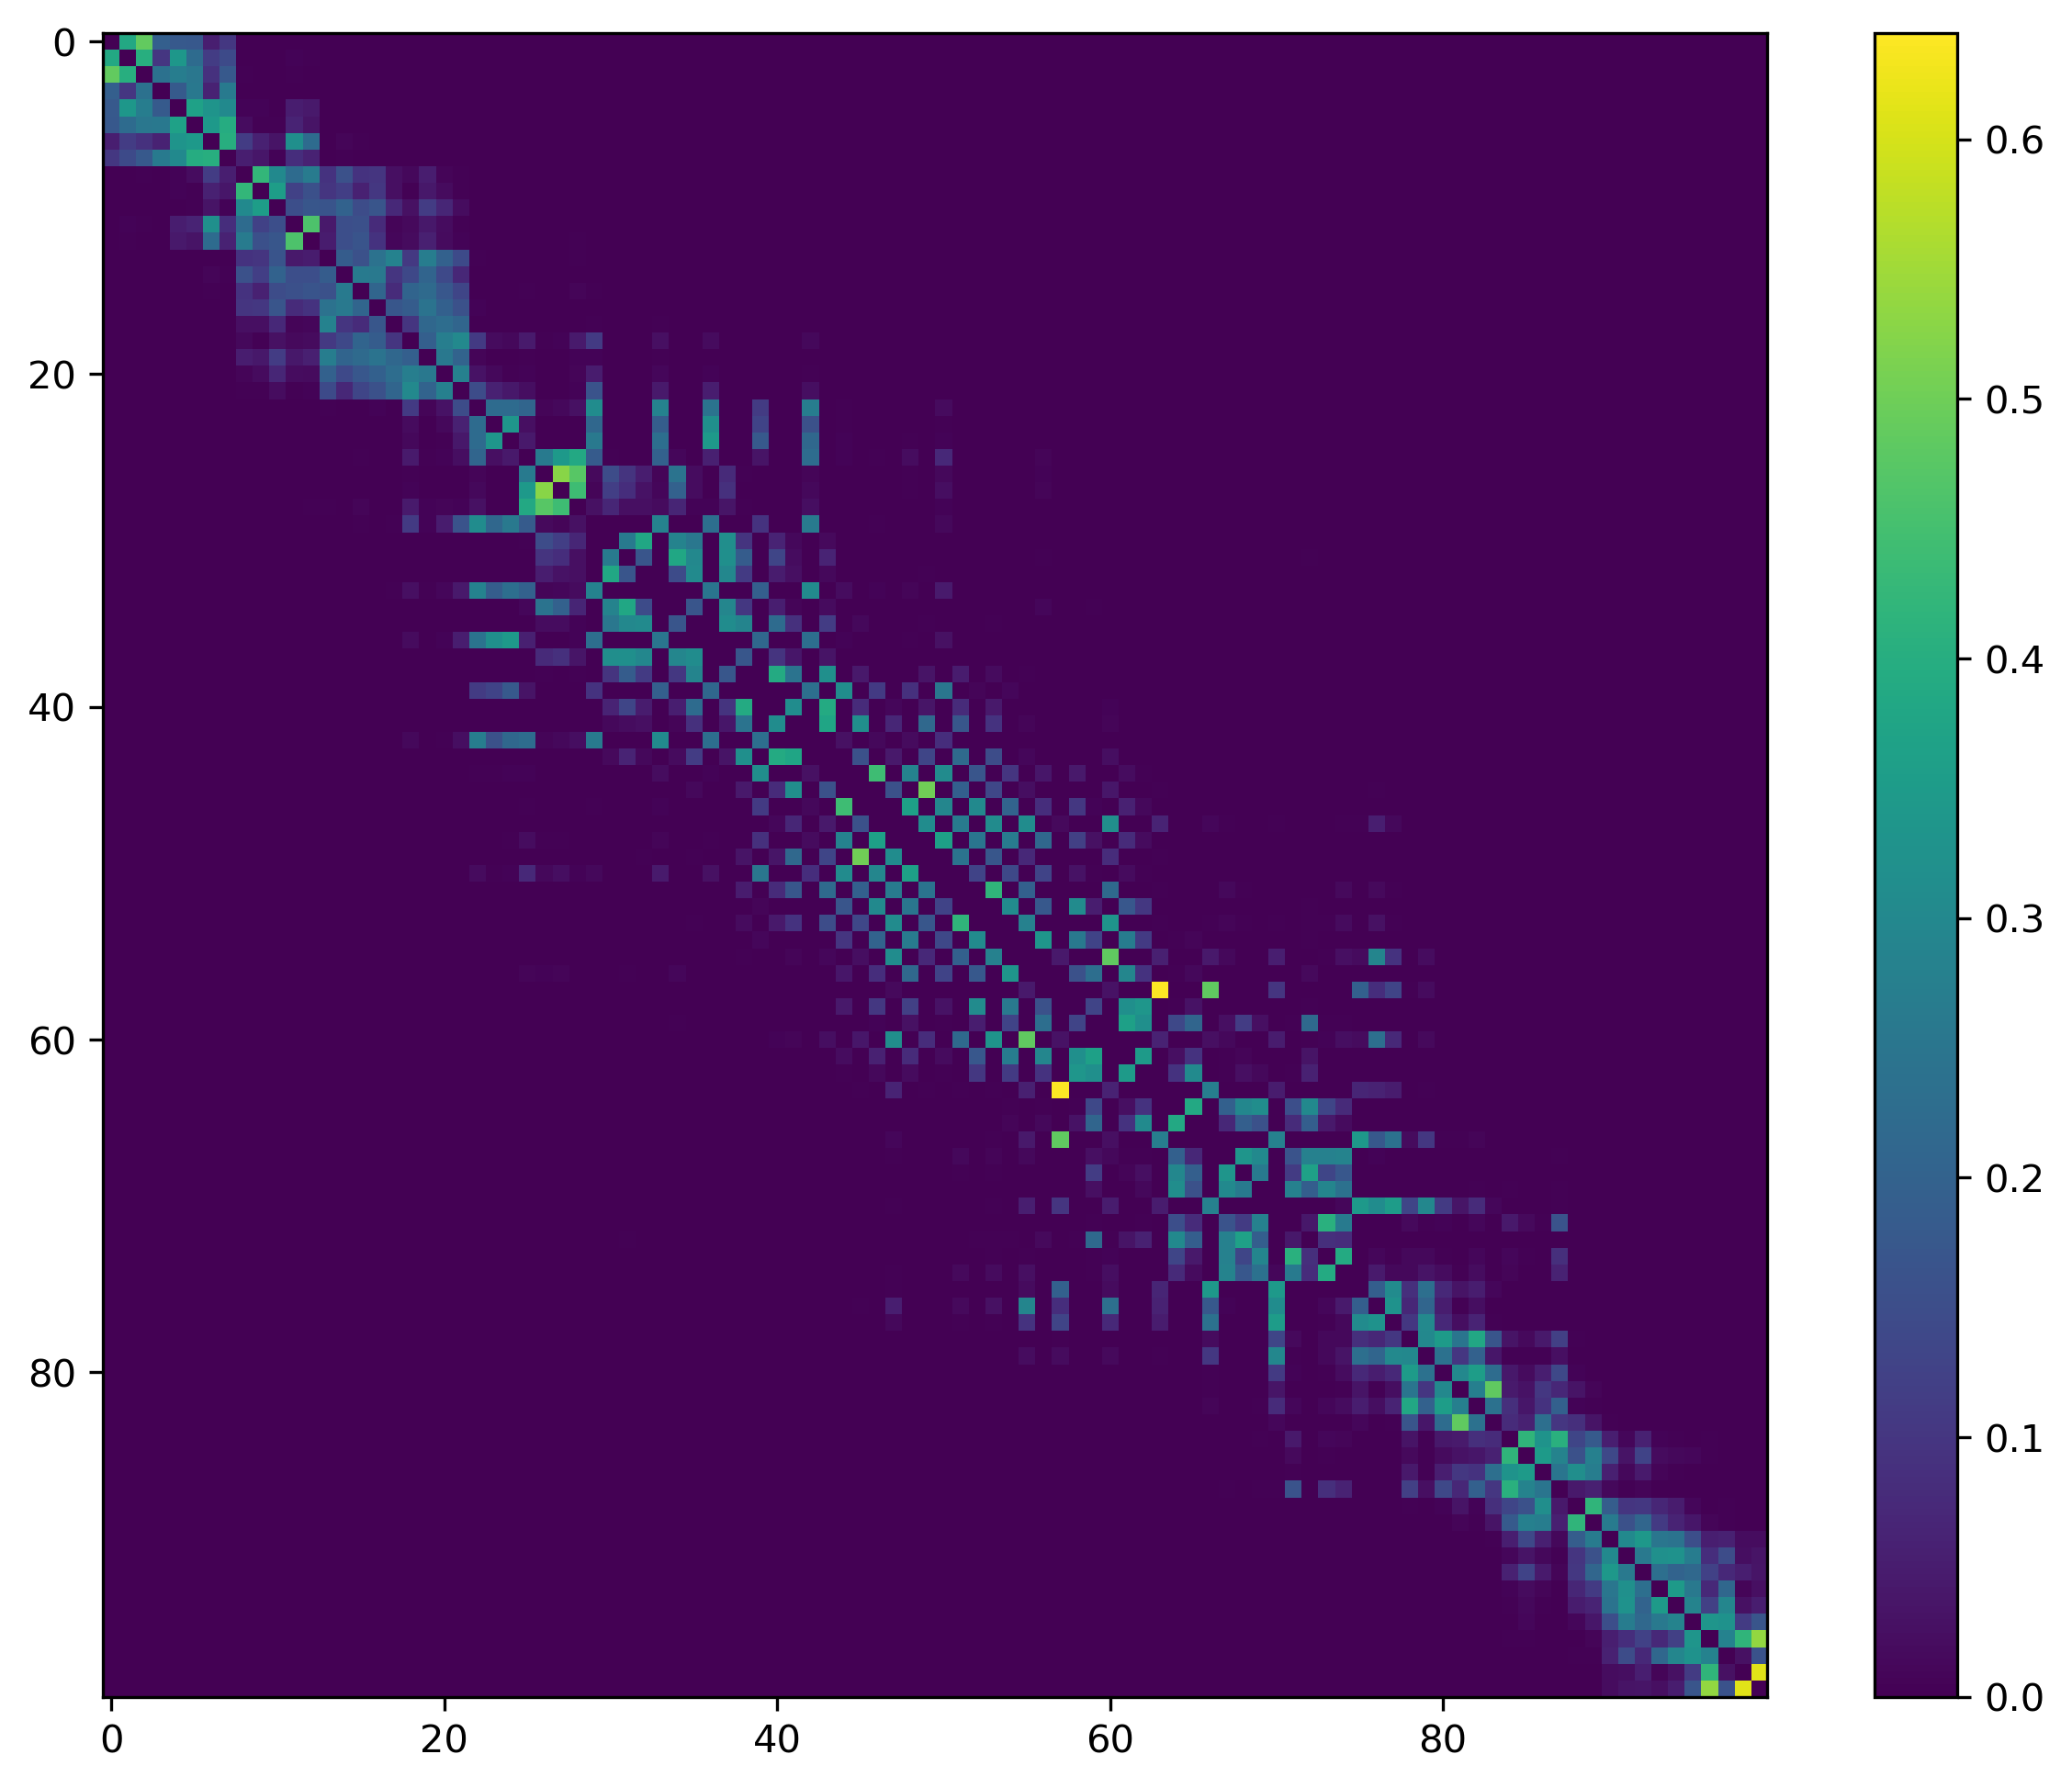

In [28]:
plt.imshow(mean_mst, vmin=0)
plt.colorbar()

In [29]:
sigma2

array([0.03275366])

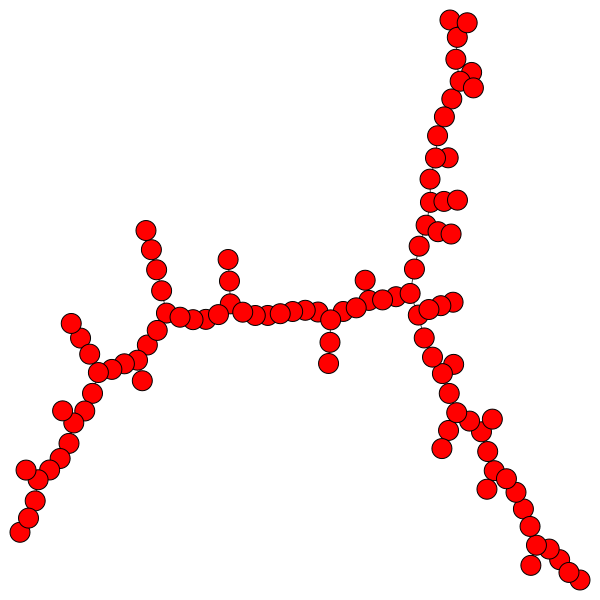

In [30]:
import igraph
import cairo


a= mst0
np.fill_diagonal(a,0)
a= a.round()

g = igraph.Graph.Adjacency((a > 0).tolist())
g.to_undirected()
layout = g.layout("kk")

igraph.plot(g, layout = layout)

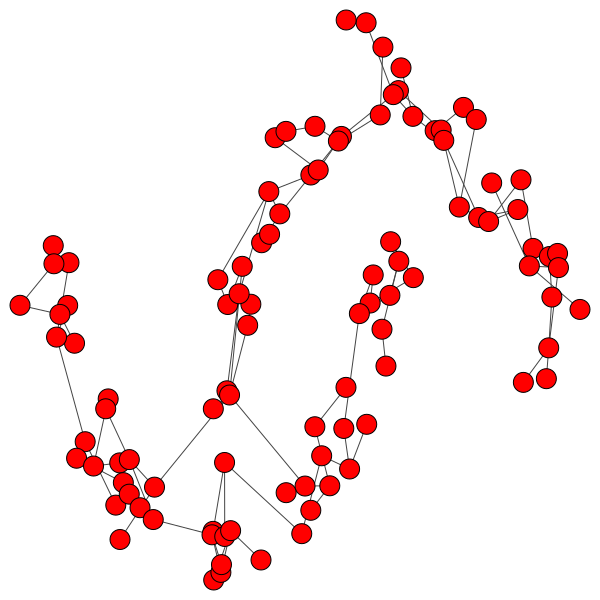

In [31]:
a= MST
np.fill_diagonal(a,0)
a= a.round()

g = igraph.Graph.Adjacency((a > 0).tolist())
g.to_undirected()

layout = zip(list(Y[:,0]), list(Y[:,1])) 
igraph.plot(g, layout = layout)